## Recommender env: implementation

In [16]:
# HIDDEN
import gym
import numpy as np

#### Implementation

Now we're ready to implement our environment. 

#### Review: what does an env need?

Requirements for an RL environment:

- Observation space
- Action space
- Constructor
- `reset()` method
- `step()` method

We'll now create all of these for our recommender environment. Let's go!

Notes:

In the previous module, we listed the following requirements for an RL environment:

#### Observation space

- The first step is to set the observation space. 
- Our observations are the _features of candidate items_.
- For simplicity, we'll assume only 1 feature.
- Here, our observations are continuous-valued, not discrete like Frozen Lake.
- If you'd like, pause for a moment and think about what the observation space should be.
  - You may wish to consult the gym library documentation [here](https://www.gymlibrary.ml/content/spaces/).

In [2]:
# TODO
# we could have a multiple choice in here
# I guess it's potentially fine to have tons of short notebooks in this module???
# might be a bit of a hassle for video recording?

#### Observation space

- We want the `Box` space:

In [3]:
# HIDDEN
num_candidates=10

In [4]:
observation_space = gym.spaces.Box(low=0, high=1, shape=(num_candidates,))

- Features are between 0 and 1, number of features is number of item candidates. 
- Here is an sample from the observation space:

In [5]:
observation_space.sample()

array([0.5112677 , 0.21406838, 0.2754315 , 0.6045677 , 0.1501461 ,
       0.8971636 , 0.42283583, 0.25541636, 0.76292586, 0.62952304],
      dtype=float32)

Looks good 👍

#### Action space

- In this environment, the action is the chosen item to recommend.
- If you'd like, pause for a moment and think about what the action space should be.
  - You may wish to consult the gym library documentation [here](https://www.gymlibrary.ml/content/spaces/).

#### Action space

Unlike the observation space, the action space _is_ discrete:

In [6]:
action_space = gym.spaces.Discrete(num_candidates)

Here are 15 randomly sampled actions:

In [7]:
[action_space.sample() for i in range(15)]

[0, 6, 4, 2, 8, 2, 2, 2, 7, 5, 2, 2, 7, 5, 7]

Looks good 👍

#### Constructor

Starting with the constructor:

In [8]:
class BasicRecommender(gym.Env):
    def __init__(self, env_config=None):
        # Set parameters    
        self.num_candidates = env_config.get("num_candidates", 10)
        self.alpha = env_config.get("alpha", 0.9)

        # Set observation and action spaces
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.num_candidates,))
        self.action_space = gym.spaces.Discrete(self.num_candidates)

Notes:

The observation and action spaces follow what we saw in the previous slide deck. 

#### Reset

Next we need our `reset()` method, which needs to:

- Reset the sugar level
- Sample/simulate random document features
- Return the observation 

In [9]:
class BasicRecommender(gym.Env):

    def reset(self):
        self.sugar_level = 0.0                
        self.documents = np.random.rand(self.num_candidates)
        return self.documents

Notes:

We'll reset the sugar level to zero, though other choices could be reasonable as well. We'll also have the features be between 0 and 1 for simplicity, and will choose them uniformly at random. Again, all of these are choices that we are making to model the real situation. We are going with the simplest choices for instructional purposes.

#### Step

- As usual, the `step()` method is the most complicated.
- However, we can make use of our `update_sugar_level` and `reward` functions from earlier.
- As a reminder, here they are again:

In [10]:
def update_sugar_level(self, item_sweetness):
    self.sugar_level = self.alpha * self.sugar_level + (1 - self.alpha) * item_sweetness

In [11]:
def reward(self, item_sweetness):
    return item_sweetness * (1 - self.sugar_level)

Notes:

We made slight modifications because alpha and sugar level are now stored in the class as self.alpha and self.sugar_level rather than being passed into the functions. 

#### Step

And now for `step()`, which needs to:

- Compute the reward
- Update the sugar level
- Simulate a set of new candidate items for the next iteration
- Return the observation, reward, and done flag

In [12]:
    def step(self, action):

        # Get the sweetness of the recommended item
        item_sweetness = self.documents[action]

        # Compute reward
        reward = self.reward(item_sweetness)

        # Update sugar level
        self.update_sugar_level(item_sweetness)

        # Generate new candidates for the next recommendation
        if self.resample_documents:
            self.documents = np.random.rand(self.num_candidates)

        # Set the done flag (not shown for brevity)
        done = False
            
        return self.documents, reward, done, {"sugar_level" : self.sugar_level}

Notes:

Some points to note here. For now, we are always returning done=False. In reality, we will set a fixed maximum number of steps before the episode ends, as shown in the previous module. However, this is not shown here for brevity.
Note also that the `step` method returns the sugar level. This is not accessed by the agent, but rather is just for our convenience as we debug/introspect the RL system. In the past, we had just ignored this optional info returned by `step`.

#### Let's test it out!

Let's test out our new environment!

In [13]:
# HIDDEN
from envs import BasicRecommender

In [14]:
env_config = {
    "num_candidates" : 2,
    "alpha"          : 0.5,
    "seed"           : 42
}

In [15]:
env = BasicRecommender(env_config)

Notes: 

We'll set the number of candidates to 2 for ease of illustration later on, and the default alpha to 0.5, meaning the new sugar level is updated to be the (unweighted) average of the old sugar level and the item sweetness. 

We set the random seed to 0 for reproducibility. 

#### Let's test it out!

In [16]:
# HIDDEN
# env.seed(42)

In [17]:
env.reset()

array([0.37454012, 0.95071431])

- This looks good.
- Since we set `num_candidates` to 2 in `env_config`, we see 2 candidates.
- Each of the numbers above represents the sweetness of a simulated item candidate.
- Let's have the agent select (recommend) the first item, with sweetness 0.37.

In [18]:
env.step(0)

(array([0.73199394, 0.59865848]),
 0.3745401188473625,
 False,
 {'sugar_level': 0.18727005942368125})

Notes:

We can observe that the sugar level went up from 0 to 1-alpha, or 0.5, times the item sweetness of 0.37. As a reminder, the sugar level info is not available to the agent, it's just for us. Note also that, after our action, a new set of candidate documents are given as the observation.

#### Baseline

Before training our agent, let's first establish two baselines:

- Greedy baseline: always pick the sweetest item
- Random baseline: pick randomly every time

#### Greedy baseline

In [19]:
env = BasicRecommender(env_config)

def greedy_agent_episode(env):
    obs = env.reset()
    total_reward = 0
    done = False
    while not done:
        sweetest_item = np.argmax(obs)
        obs, reward, done, info = env.step(sweetest_item)
        total_reward += reward
    return total_reward

Because of the randomness of the item sweetness values, we should repeat this for many episodes and take the average:

In [23]:
np.mean([greedy_agent_episode(env) for episode in range(1000)])

23.078751951739157

- We can get a reward of 23.1 by always picking the sweetest items.
- To make this more exciting, assume this is \\$23.1 for our business, and we have 1M users, so \\$23.1M.

Notes:

This is the total for 100 time steps, or around $0.23 per time step. If we were to have longer episodes, this number would be larger.

#### Random baseline

Now let's try a random approach:

Notes: 

Here, the agent recommends a random item from the 10 candidates each time.

In [25]:
env = BasicRecommender(env_config)

def random_agent_episode(env):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        random_item = np.random.randint(len(obs))
        obs, reward, done, info = env.step(random_item)
        total_reward += reward
    return total_reward

Because of the randomness, we should repeat this for many episodes and take the average:

In [27]:
np.mean([random_agent_episode(env) for episode in range(1000)])

25.525583133463225

- With random actions, we do better: around $25.5M revenues.
- Time to pay me a bonus! 💰

#### Let's apply what we learned!

## Improving the user model
<!-- multiple choice -->

We created a very simple user model/simulation for this example. Which of the following would **NOT** be a reasonable extension to our user model for a recommender system?

- [ ] Increase the number of features that we use to represent each item candidate.
- [ ] Account for features of each user rather than treating all users as the same.
- [ ] Capture user interaction more richly, e.g. which items they click on, or consume/purchase.
- [x] Simulate the neurons in the user's brain and how they react to item recommendations.

## Greedy vs. random
<!-- multiple choice -->

Above, we saw our random baseline outperform our greedy baseline. Do you think this would always be the case?

- [ ] The random strategy always outperforms the greedy strategy. | What if the episode only had 1 step?
- [ ] The greedy strategy always outperforms the random strategy. | We saw the random strategy do better, though.
- [x] The random strategy performs better vs. greedy as the episode duration increases. | The greedy strategy works in the short-term, but not the long term.
- [ ] The greedy strategy performs better vs. random as the episode duration increases. | I think you have this backwards.

## Greedy vs. random continued
<!-- coding exercise -->

In the previous question we decided that the random strategy should perform better for long episodes but that the greedy method might be better for short episodes. For example, if the entire episode consists of only a single recommendation, we just want the sweetest item. Test this relationship empirically by filling in the missing code. 

In [1]:
# EXERCISE

import numpy as np
import matplotlib.pyplot as plt
from envs import BasicRecommender

def baseline_episode(env, method="greedy"):
    """
    Compute the episode reward for a BasicRecommender env by either
    acting greedy (max observation) or acting randomly.
    Return total reward.
    """
    obs = env.reset()
    total_reward = 0
    done = False
    while not done:
        if method == "greedy":
            chosen_item = np.argmax(____)
        elif method == "random":
            chosen_item = np.random.randint(____)
        else:
            raise Exception("Unknown method.")
        obs, reward, done, info = env.____(chosen_item)
        total_reward += reward
    return total_reward

def baseline_multiple_episodes(env, method, n_ep=100):
    """ Compute baseline reward averaged over multiple episodes """
    return np.mean([baseline_episode(env, method) for ep in range(n_ep)])

max_steps = [1,3,10,30,100] # The different horizon lengths to test out
greedy_results = []
random_results = []

# Run the simulations
for ms in ____:
    env = BasicRecommender({"max_steps" : ____})
    greedy_results.append(baseline_multiple_episodes(env, "greedy"))
    random_results.append(baseline_multiple_episodes(env, "random"))
    
# Plotting code (you can ignore)
plt.plot(max_steps, greedy_results, label="greedy")
plt.plot(max_steps, random_results, label="random")
plt.legend();
plt.xlabel("horizon of the env");
plt.ylabel("episode reward");

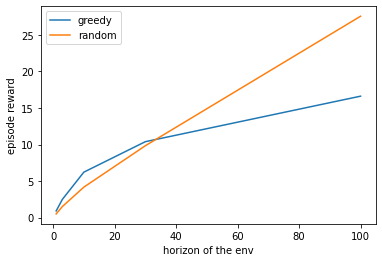

In [6]:
# SOLUTION

import numpy as np
import matplotlib.pyplot as plt
from envs import BasicRecommender

def baseline_episode(env, method="greedy"):
    """
    Compute the episode reward for a BasicRecommender env by either
    acting greedy (max observation) or acting randomly.
    Return total reward.
    """
    obs = env.reset()
    total_reward = 0
    done = False
    while not done:
        if method == "greedy":
            chosen_item = np.argmax(obs)
        elif method == "random":
            chosen_item = np.random.randint(len(obs))
        else:
            raise Exception("Unknown method.")
        obs, reward, done, info = env.step(chosen_item)
        total_reward += reward
    return total_reward

def baseline_multiple_episodes(env, method, n_ep=100):
    """ Compute baseline reward averaged over multiple episodes """
    return np.mean([baseline_episode(env, method) for ep in range(n_ep)])

max_steps = [1,3,10,30,100] # The different horizon lengths to test out
greedy_results = []
random_results = []

# Run the simulations
for ms in max_steps:
    env = BasicRecommender({"max_steps" : ms})
    greedy_results.append(baseline_multiple_episodes(env, "greedy"))
    random_results.append(baseline_multiple_episodes(env, "random"))
    
# Plotting code (you can ignore)
plt.plot(max_steps, greedy_results, label="greedy")
plt.plot(max_steps, random_results, label="random")
plt.legend();
plt.xlabel("horizon of the env");
plt.ylabel("episode reward");